In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from matplotlib import cm
from shapely import geometry
from quetzal.model import stepmodel
from syspy.skims import skims

In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none func

# Preparation of the LoS tables
## Validates rail service connections
## Needs PT LoS table

In [2]:
input_path = '../input_static/level_of_service/'
output_path = '../output/'
model_path = '../model/'

In [3]:
sm = stepmodel.read_json(model_path + scenario + '/' + 'de_pt_los')

In [4]:
ln = stepmodel.read_json(model_path + 'de_pt_network_agg')
sm.zones = ln.zones

## Prepare the validation data
It had been fetched manually from the DB website beginning of January 2021, searching for trips two weeks ahead during early daytime.

In [5]:
val = pd.read_excel(input_path + 'validation_rail.xls', header=None, engine='xlrd')
val.columns = ['city', 'time', 'duration', 'ntransfers', 'services', 'cost_spar', 'cost_flex']

In [6]:
# Get the names right
val['city'] = val['city'].replace({'Hauptbahnhof, Bonn': 'Bonn'}).str.split(' ')
val['city'] = [l[0].split('(')[0] for l in list(val['city'])]

In [7]:
# Get origin and destination
d = [val.iloc[i, 0] for i in range(1, len(val), 2)]
val = val.iloc[::2, :].rename(columns={'city': 'o'})
val['d'] = d

In [8]:
# Get the times right
val.drop('time', axis=1, inplace=True)
val['duration'] = val['duration'].astype(str).str.split(':')
val['duration'] = [int(l[0]) + float(l[1])/60 for l in list(val['duration'])]

In [9]:
# Get the prices right
for col in ['cost_spar', 'cost_flex']:
    val[col] = [l[0] for l in list(val[col].str.split(','))]
    val[col] = val[col].astype(float)

In [10]:
val.head(4)

,o,duration,ntransfers,services,cost_spar,cost_flex,d
0,Hamburg,2.050000,0.0,ICE,29.0,75.0,Berlin
2,Hamburg,1.750000,0.0,ICE,29.0,75.0,Berlin
4,Köln,4.366667,0.0,ICE,29.0,114.0,Berlin
6,Köln,4.433333,0.0,ICE,39.0,114.0,Berlin


In [11]:
sm.zones['name'] = [l[0] for l in list(sm.zones['NUTS_NAME'].str.split(' '))]
sm.zones['name'] = [l[0] for l in list(sm.zones['name'].str.split(','))]
sm.zones['name'] = [l[0] for l in list(sm.zones['name'].str.split('('))]

In [12]:
# Length of zones with matching name
print(len(sm.zones.sort_values('urbanisation').loc[sm.zones['name'].isin(set(list(val[['o', 'd']].stack())))].drop_duplicates('name')))
print(len(set(list(val[['o', 'd']].stack()))))

27
34


In [13]:
# Generate a dictionary
nuts_dict = sm.zones.sort_values('urbanisation').loc[
    sm.zones['name'].isin(set(list(val[['o', 'd']].stack())))
].drop_duplicates('name').set_index('name')['NUTS_ID'].to_dict()

In [14]:
# Add missing zone IDs
missing = list(set(list(val[['o', 'd']].stack())) - set(nuts_dict.keys()))
missing.sort()
missing

['Hannover',
 'Kassel-Wilhelmshöhe',
 'Kelkheim',
 'Rheine',
 'Siegen',
 'Stralsund',
 'Zimmersrode']

In [15]:
missing_ids = ['DE929', 'DE731', 'DE71A', 'DEA37', 'DEA5A', 'DE80L', 'DE735']
nuts_dict.update({missing[i]: missing_ids[i] for i in range(len(missing))})

In [16]:
# Map names to IDs
val['o_nuts'] = val['o'].map(nuts_dict)
val['d_nuts'] = val['d'].map(nuts_dict)

In [17]:
# Get the distance as the crow flies
try:
    centroids = sm.zones.centroid
except AttributeError:
    sm.zones = gpd.GeoDataFrame(sm.zones)
    centroids = sm.zones.centroid
val['distance'] = skims.distance_from_geometry(pd.Series(
    [geometry.LineString([centroids.loc[od[0]], centroids.loc[od[1]]])
     for od in val[['o_nuts', 'd_nuts']].values])) / 1000

In [18]:
# Merge
val = val.merge(sm.pt_los[
    ['origin', 'destination', 'length', 'time', 'price', 'ntransfers', 'link_path', 'route_type', 'route_types', 'in_vehicle_time']
].loc[sm.pt_los['route_type'].str.startswith('rail')], #.isin(['rail_long', 'rail_short', 'bus', 'coach', 'rail'])]
                how='left', left_on=['o_nuts', 'd_nuts'], right_on=['origin', 'destination'])
val.head(2)

,o,duration,ntransfers_x,services,cost_spar,cost_flex,d,o_nuts,d_nuts,distance,origin,destination,length,time,price,ntransfers_y,link_path,route_type,route_types,in_vehicle_time
0,Hamburg,2.05,0.0,ICE,29.0,75.0,Berlin,DE600,DE300,254.789375,DE600,DE300,276205,3.282222,13.761667,0,[c_7613],bus,[coach],10800
1,Hamburg,2.05,0.0,ICE,29.0,75.0,Berlin,DE600,DE300,254.789375,DE600,DE300,241407,1.056389,27.933071,0,[rl_494],rail,[rail_long],2760


In [19]:
# All connections should exist in the model
val.loc[val['link_path'].isna()]

,o,duration,ntransfers_x,services,cost_spar,cost_flex,d,o_nuts,d_nuts,distance,origin,destination,length,time,price,ntransfers_y,link_path,route_type,route_types,in_vehicle_time


In [20]:
lines = [geometry.LineString([ln.links.loc[i, 'geometry'].coords[0] for i in l]
                             + [ln.links.loc[l[-1], 'geometry'].coords[-1]])
         for l in list(val.loc[val['link_path'].notna(), 'link_path'])]
gdf = gpd.GeoDataFrame(data={'ind': range(len(lines))}, geometry=lines)
cmap = cm.get_cmap('gist_rainbow')

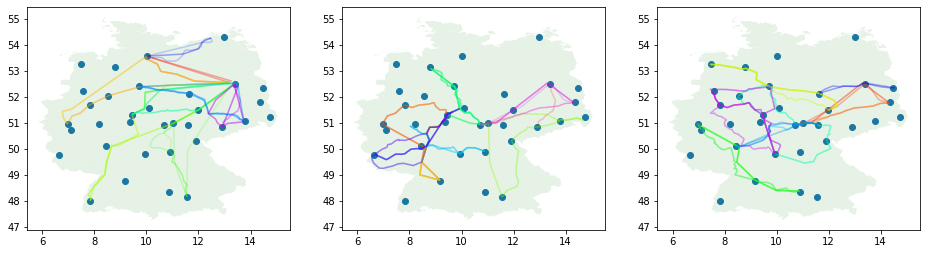

In [21]:
nplots = 3
cut = int(len(gdf)/nplots)
fix, axes = plt.subplots(nrows=1, ncols=nplots, figsize=(16,16))
for i in range(nplots):
    gdf.iloc[i*cut:(i+1)*cut].plot(cmap=cmap, alpha=.2, ax=sm.zones.plot(
        color='g', alpha=.1, ax=centroids.loc[set(val[['o_nuts', 'd_nuts']].stack())].plot(ax=axes[i])))

In [23]:
gdf['route_type'] = list(val.loc[val['link_path'].notna(), 'route_type'])
gdf.to_file(output_path + 'validation_rail.geojson', driver='GeoJSON')

In [23]:
def get_trend(x, y, label):
    z = np.polyfit(x, y, deg=1)
    p = np.poly1d(z)
    plt.plot(x, p(x), linestyle='--', marker=' ', label=label)
    plt.scatter(x, y, marker='o', alpha=.2, label=label)
    print('{}: y={}*x+{}'.format(label, np.round(z[0], 3), np.round(z[1], 3)))

## Distance
Comparing as-the-crow-flies air distance and length of the model paths

In [24]:
# Convert to km
val['length'] = val['length'] / 1000

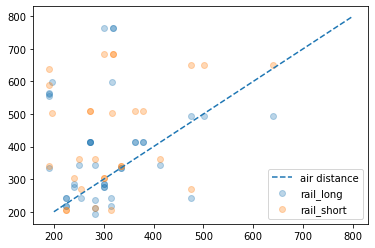

In [25]:
# X-axis is the direct distance between centroids
# Y-axis is the length of the corresponding route
for t in ['rail_long', 'rail_short']:
    plt.scatter(val.loc[val['route_type']==t]['distance'],
                val.loc[val['route_type']==t]['length'],
                marker='o', alpha=.3, label=t)
plt.plot([200,800], [200,800], linestyle='--', marker='', label='air distance')
plt.legend()

## Time
The PT graph should hold reasonable connections for the rail mode. Coach services are uncritical because they were not aggregated and persist as they come from GTFS feeds. Rail connections on the other hand relie on long- and short-distance trips which are algorithmically connected and aggregated.

In [26]:
# Convert to hours
val['time'] = val['time'] / 3600 if val['time'].mean()>3600 else val['time']
val['in_vehicle_time'] = val['in_vehicle_time'] / 3600

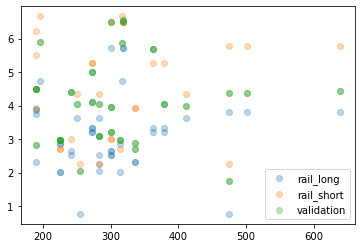

In [27]:
# Compare in-vehicle time
for t in ['rail_long', 'rail_short']:
    plt.scatter(val.loc[val['route_type']==t]['distance'],
                val.loc[val['route_type']==t]['in_vehicle_time'],
                marker='o', alpha=.3, label=t)
plt.scatter(val['distance'], val['duration'], marker='o', alpha=.3, label='validation')
plt.legend()

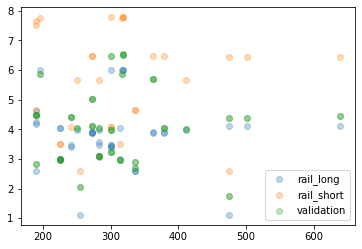

In [28]:
# Whole-path time
for t in ['rail_long', 'rail_short']:
    plt.scatter(val.loc[val['route_type']==t]['distance'],
                val.loc[val['route_type']==t]['time'],
                marker='o', alpha=.3, label=t)
plt.scatter(val['distance'], val['duration'], marker='o', alpha=.3, label='validation')
plt.legend()

rail_long: y=0.792*x+-0.067
rail_short: y=0.857*x+0.676


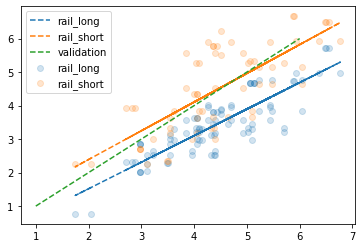

In [29]:
# In-vehicle time
for t in ['rail_long', 'rail_short']:
    x = val.loc[val['route_type']==t]['duration']
    y = val.loc[val['route_type']==t]['in_vehicle_time']
    get_trend(x, y, t)
plt.plot([1,6], [1,6], linestyle='--', marker='', label='validation')
plt.legend()

rail_long: y=0.807*x+0.639
rail_short: y=1.027*x+1.055


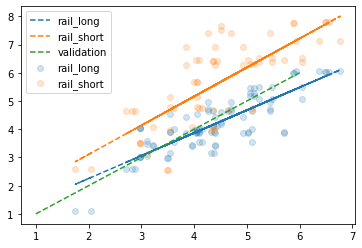

In [30]:
# Now for whole-path time
for t in ['rail_long', 'rail_short']:
    x = val.loc[val['route_type']==t]['duration']
    y = val.loc[val['route_type']==t]['time']
    get_trend(x, y, t)
plt.plot([1,6], [1,6], linestyle='--', marker='', label='validation')
plt.legend()

## Prices
In long-distance rail transport, there are "Sparpreise" which divert from regular distance-based price generation

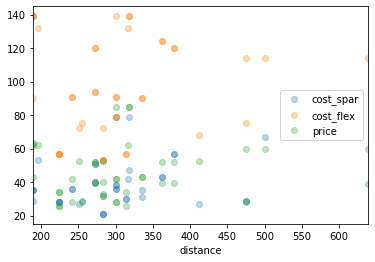

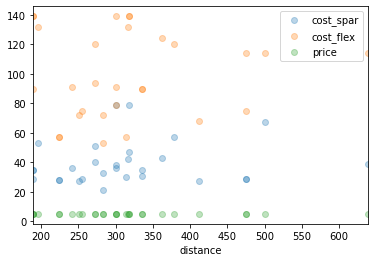

In [31]:
for t in ['rail_long', 'rail_short']:
    val.loc[val['route_type']==t][['cost_spar', 'cost_flex', 'price', 'distance']
                                 ].set_index('distance').plot(linestyle=' ', marker='o', alpha=.3)

In [32]:
sm.pt_los['length'] = sm.pt_los['length'] / 1000

rail_long: y=0.086*x+11.862
rail_short: y=0.024*x+31.499
Sparpreis: y=0.057*x+18.309
Flexpreis: y=0.157*x+32.993


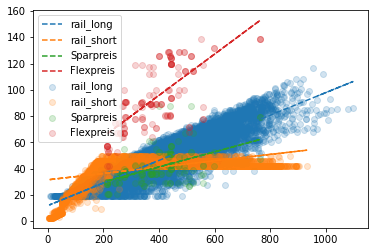

In [33]:
for t in ['rail_long', 'rail_short']:
    sample = sm.pt_los.loc[sm.pt_los['route_type']==t].sample(10000)
    try:
        get_trend(sample['length'], sample['price'], t)
    except:
        plt.scatter(sample['length'], sample['price'], marker='o', alpha=.2, label=t)
get_trend(val['length'], val['cost_spar'], 'Sparpreis')
get_trend(val['length'], val['cost_flex'], 'Flexpreis')
plt.legend()

In [34]:
# Perform a regression analysis to find the distance-duration (explainatory variables)
# dependency of prices (dependent variable)
sample = val.drop_duplicates(['o', 'd', 'duration'])
X = sample[['duration', 'length']].values # in hours, km
# Differentiate by price types
for price in ['cost_spar', 'cost_flex']:
    Y = sample[price].values
    model = LinearRegression().fit(X, Y)
    r_sq = model.score(X, Y)
    print(price)
    print('Coefficient of determination (R²): ', r_sq)
    print('Intercept:', model.intercept_)
    print('Slopes:', model.coef_)

cost_spar
Coefficient of determination (R²):  0.47014240627182274
Intercept: 4.307364085495422
Slopes: [5.74327105 0.02568139]
cost_flex
Coefficient of determination (R²):  0.6415857399814295
Intercept: 20.205445031953047
Slopes: [6.26725016 0.1145613 ]


In [35]:
# Save the merged validation table
writer = pd.ExcelWriter(output_path + 'validation_rail_merged.xlsx', engine='xlsxwriter')
val.to_excel(writer)
writer.save()